In [1]:
# -.-|m { input: false, output: false }

# use this to export to html 
# jupyter nbconvert --to html --no-input  4_PAD_modelin.ipynb
# jupyter nbconvert 4_PAD_modelin.ipynb --to html --no-prompt --template myTPL/
## pretty jupyter template
# jupyter nbconvert --to html --template pj .\4_PAD_modelin.ipynb
%load_ext pretty_jupyter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt ,re
# from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from tableone import TableOne

In [2]:
def plot_importance(series: pd.Series, title:str = "Feature Importance"):
    f, ax = plt.subplots(figsize=(5, 8))
    sns.set_color_codes("pastel")
    sns.barplot(x = series.values, y = series.index, color="r", ax=ax)
    ax.set_title(title)
    ax.axvline(x=series.mean(), label = "mean importance measure")
    plt.legend()
    plt.show()

# Intro

This file is created after the initial modeling and cleaning step "3_PAD_MODELING" was done on the PAD study.

Here, I will go deeper in my approach to the exploratory data analysis and producing charts and plots about our predictors.

Also, the the modeling would be enhanced based on the feedbacks.

Here shows the first rows of data

In [3]:
pd.set_option('display.max_columns', 10)

df = pd.read_csv("./Data/processed_panel_1and3.csv")

PROTEINS = df.iloc[:,1:df.columns.get_loc("Age")].columns.to_list()
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Smoking Hx',
       #  'Dialysis', # Zero variance
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       # 'oral hypoglyc' # correlated with Diabetes
       ]

TARGET = ["hasPAD"]
df.head(10)

,ID,IL-33,uPAR,CXCL6,ESM-1,...,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc,hasPAD
0,5,14.091162,557.896234,110.729424,1055.750683,...,0.0,0.0,0.0,NaN,0
1,14,33.331707,2383.453789,128.812424,472.920153,...,0.0,0.0,1.0,1.0,0
2,92,19.413896,922.174636,207.177434,983.060117,...,0.0,0.0,0.0,0.0,0
3,119,59.897453,2734.344683,645.989311,1323.804448,...,1.0,1.0,0.0,0.0,0
4,124,37.126933,4847.796709,268.216338,991.308486,...,0.0,0.0,0.0,1.0,0
5,125,22.044376,2206.218500,489.488196,673.253730,...,1.0,0.0,0.0,0.0,0
6,128,57.620453,2677.087531,380.001801,594.683007,...,1.0,0.0,0.0,0.0,0
7,133,10.027423,908.157598,199.410118,275.997849,...,0.0,0.0,0.0,0.0,0
8,209,22.699279,1145.192116,189.496576,195.253624,...,0.0,0.0,0.0,0.0,0
9,215,22.044376,950.177351,364.212070,619.267925,...,0.0,0.0,0.0,0.0,0


In [4]:
df.shape

(461, 65)

# Exploratory Analysis


## Proteins

Basic statistics from the proetins in panel

In [5]:
df.hasPAD.value_counts()

1    295
0    166
Name: hasPAD, dtype: int64

In [6]:
pd.set_option('display.colheader_justify', 'right')
df_viz = df.copy()
df_viz['hasPAD'] = df_viz['hasPAD'].map({0: 'Without PAD', 1: "With PAD"})

table1 = TableOne(df_viz, columns=PROTEINS,groupby=["hasPAD"], pval=True, htest_name=True, dip_test=True, tukey_test=True)

In [7]:
%%jmd

{{table1.to_html()}}


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="6" halign="left">Grouped by hasPAD</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>Missing</th>
      <th>Overall</th>
      <th>With PAD</th>
      <th>Without PAD</th>
      <th>P-Value</th>
      <th>Test</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>n</th>
      <th></th>
      <td></td>
      <td>461</td>
      <td>295</td>
      <td>166</td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>IL-33, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>27.1 (22.6)</td>
      <td>27.2 (15.3)</td>
      <td>27.0 (31.7)</td>
      <td>0.918</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>uPAR, mean (SD)</th>
      <th></th>
      <td>15</td>
      <td>1910.5 (959.5)</td>
      <td>2020.8 (979.5)</td>
      <td>1713.4 (892.3)</td>
      <td>0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>CXCL6, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>240.3 (184.3)</td>
      <td>235.3 (163.9)</td>
      <td>249.1 (216.2)</td>
      <td>0.475</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>ESM-1, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>597.2 (290.2)</td>
      <td>592.2 (278.8)</td>
      <td>606.0 (310.2)</td>
      <td>0.634</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>SCF, mean (SD)</th>
      <th></th>
      <td>15</td>
      <td>111.9 (49.0)</td>
      <td>117.6 (52.6)</td>
      <td>101.5 (39.8)</td>
      <td>&lt;0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>TSG-14, mean (SD)</th>
      <th></th>
      <td>14</td>
      <td>1324.6 (636.0)</td>
      <td>1387.1 (687.3)</td>
      <td>1214.6 (517.7)</td>
      <td>0.003</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>IL-2, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>70.9 (32.5)</td>
      <td>73.0 (33.0)</td>
      <td>67.1 (31.3)</td>
      <td>0.056</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>PCSK9, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>167133.9 (478289.2)</td>
      <td>177207.1 (567648.3)</td>
      <td>149232.8 (251211.4)</td>
      <td>0.466</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>RAGE, mean (SD)</th>
      <th></th>
      <td>7</td>
      <td>2461.3 (1462.5)</td>
      <td>2582.2 (1681.9)</td>
      <td>2236.9 (889.2)</td>
      <td>0.004</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>CD62P, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>32637.7 (14142.5)</td>
      <td>32620.2 (12084.3)</td>
      <td>32668.8 (17245.5)</td>
      <td>0.974</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>ADAMTS13, mean (SD)</th>
      <th></th>
      <td>12</td>
      <td>1077422.7 (501757.5)</td>
      <td>1021613.4 (446577.8)</td>
      <td>1176294.7 (575232.6)</td>
      <td>0.003</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Tpo, mean (SD)</th>
      <th></th>
      <td>9</td>
      <td>1544.8 (755.4)</td>
      <td>1612.9 (864.9)</td>
      <td>1420.4 (474.8)</td>
      <td>0.002</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Tie-2, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>16285.1 (8698.9)</td>
      <td>16369.3 (8760.8)</td>
      <td>16135.6 (8612.1)</td>
      <td>0.781</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>KIM-1, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>100.4 (80.8)</td>
      <td>101.7 (84.5)</td>
      <td>98.3 (73.8)</td>
      <td>0.653</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>ICAM-1, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>748798.6 (637652.1)</td>
      <td>734235.7 (625186.5)</td>
      <td>774678.4 (660349.0)</td>
      <td>0.520</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Angiopoietin-1, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>10734.4 (11430.8)</td>
      <td>10893.5 (11702.7)</td>
      <td>10451.6 (10960.0)</td>
      <td>0.685</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>TNF RII, mean (SD)</th>
      <th></th>
      <td>13</td>
      <td>3119.0 (2191.3)</td>
      <td>3387.4 (2513.8)</td>
      <td>2626.5 (1289.1)</td>
      <td>&lt;0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>TNF RI, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>1785.6 (1337.7)</td>
      <td>1919.2 (1487.2)</td>
      <td>1548.1 (979.4)</td>
      <td>0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>BMP-2, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>40.7 (18.6)</td>
      <td>40.1 (20.9)</td>
      <td>41.7 (13.7)</td>
      <td>0.319</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>ANGPTL3, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>47866.8 (22404.5)</td>
      <td>45571.2 (22167.6)</td>
      <td>51946.4 (22308.3)</td>
      <td>0.003</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>ANGPTL4, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>179933.6 (95839.2)</td>
      <td>192550.7 (99812.5)</td>
      <td>157511.8 (84055.1)</td>
      <td>&lt;0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>CD40 Ligand, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>2240.1 (1867.6)</td>
      <td>2280.1 (1924.2)</td>
      <td>2168.9 (1765.9)</td>
      <td>0.530</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>CD40, mean (SD)</th>
      <th></th>
      <td>0</td>
      <td>494.1 (462.5)</td>
      <td>530.4 (548.0)</td>
      <td>429.7 (234.4)</td>
      <td>0.006</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>CXCL1, mean (SD)</th>
      <th></th>
      <td>18</td>
      <td>237.5 (152.3)</td>
      <td>251.1 (174.0)</td>
      <td>213.0 (98.0)</td>
      <td>0.003</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>NT- pro BNP, mean (SD)</th>
      <th></th>
      <td>35</td>
      <td>567.0 (2463.3)</td>
      <td>330.5 (1581.2)</td>
      <td>960.3 (3435.6)</td>
      <td>0.030</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Ck-MB, mean (SD)</th>
      <th></th>
      <td>35</td>
      <td>5599.2 (5175.6)</td>
      <td>5427.9 (5720.4)</td>
      <td>5884.0 (4114.6)</td>
      <td>0.341</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Troponin I, mean (SD)</th>
      <th></th>
      <td>35</td>
      <td>1156.7 (4298.8)</td>
      <td>747.8 (2315.9)</td>
      <td>1836.4 (6301.7)</td>
      <td>0.037</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>FABP4, mean (SD)</th>
      <th></th>
      <td>59</td>
      <td>23640.7 (35467.4)</td>
      <td>22309.4 (39661.2)</td>
      <td>26187.4 (25540.6)</td>
      <td>0.236</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>FABP3 1value (pg/ml) baseline, mean (SD)</th>
      <th></th>
      <td>36</td>
      <td>3962.5 (2142.5)</td>
      <td>3849.7 (2259.3)</td>
      <td>4149.2 (1926.1)</td>
      <td>0.147</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>ANGPTL6, mean (SD)</th>
      <th></th>
      <td>13</td>
      <td>33976.9 (18748.1)</td>
      <td>31777.9 (14769.9)</td>
      <td>37784.8 (23709.6)</td>
      <td>0.004</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>TNFRSF9/CD137, mean (SD)</th>
      <th></th>
      <td>3</td>
      <td>81.0 (75.0)</td>
      <td>82.1 (68.4)</td>
      <td>79.1 (85.6)</td>
      <td>0.704</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Alpha 1-Microglobulin, mean (SD)</th>
      <th></th>
      <td>7</td>
      <td>16216386.6 (7221360.7)</td>
      <td>17029572.6 (7483397.2)</td>
      <td>14778435.8 (6509944.6)</td>
      <td>0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Galectin-9, mean (SD)</th>
      <th></th>
      <td>5</td>
      <td>10099.7 (5179.1)</td>
      <td>10561.1 (5419.4)</td>
      <td>9293.5 (4636.6)</td>
      <td>0.009</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>PBEF/Visfatin, mean (SD)</th>
      <th></th>
      <td>17</td>
      <td>24587.5 (57667.4)</td>
      <td>19244.8 (39799.9)</td>
      <td>33978.7 (79224.1)</td>
      <td>0.028</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Endoglin/CD105, mean (SD)</th>
      <th></th>
      <td>6</td>
      <td>3094.3 (2381.6)</td>
      <td>3098.9 (2473.3)</td>
      <td>3086.2 (2217.1)</td>
      <td>0.955</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Cathepsin S, mean (SD)</th>
      <th></th>
      <td>16</td>
      <td>3692.9 (1596.8)</td>
      <td>3863.5 (1675.2)</td>
      <td>3383.0 (1396.1)</td>
      <td>0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>APRIL/TNFSF13, mean (SD)</th>
      <th></th>
      <td>9</td>
      <td>605.0 (593.6)</td>
      <td>657.9 (684.1)</td>
      <td>511.2 (367.5)</td>
      <td>0.003</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Galectin-1, mean (SD)</th>
      <th></th>
      <td>6</td>
      <td>45086.3 (19256.6)</td>
      <td>46683.2 (20052.5)</td>
      <td>42306.1 (17498.8)</td>
      <td>0.015</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>ALCAM/CD166, mean (SD)</th>
      <th></th>
      <td>10</td>
      <td>12377.4 (5320.4)</td>
      <td>12779.3 (5705.6)</td>
      <td>11653.6 (4471.4)</td>
      <td>0.021</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>EpCAM/TROP1, mean (SD)</th>
      <th></th>
      <td>3</td>
      <td>973.8 (762.4)</td>
      <td>992.7 (721.2)</td>
      <td>940.7 (831.1)</td>
      <td>0.500</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Furin, mean (SD)</th>
      <th></th>
      <td>3</td>
      <td>2357.2 (1117.5)</td>
      <td>2335.2 (1075.4)</td>
      <td>2395.9 (1190.3)</td>
      <td>0.587</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>GDF-15, mean (SD)</th>
      <th></th>
      <td>3</td>
      <td>1717.3 (1787.1)</td>
      <td>2050.1 (2088.1)</td>
      <td>1131.8 (784.4)</td>
      <td>&lt;0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Chemerin, mean (SD)</th>
      <th></th>
      <td>12</td>
      <td>9857.6 (8474.8)</td>
      <td>10475.5 (10048.2)</td>
      <td>8763.0 (4314.0)</td>
      <td>0.013</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Endostatin, mean (SD)</th>
      <th></th>
      <td>5</td>
      <td>63495.9 (53504.2)</td>
      <td>70205.0 (62429.3)</td>
      <td>51775.1 (29161.8)</td>
      <td>&lt;0.001</td>
      <td>Two Sample T-test</td>
    </tr>
    <tr>
      <th>Aggrecan, mean (SD)</th>
      <th></th>
      <td>7</td>
      <td>2212.8 (2240.6)</td>
      <td>2314.6 (2325.9)</td>
      <td>2034.4 (2077.6)</td>
      <td>0.187</td>
      <td>Two Sample T-test</td>
    </tr>
  </tbody>
</table>

## Correlation analysis on proteins

- Now let's take a closer look at the proteins with significant (p-value < 0.05) difference among PAD and non-PAD patients.
- Below the most-correlated pairs are plotted

In [8]:
numerical_sig = ['uPAR', 'SCF', 'TSG-14', 'RAGE', 'ADAMTS13', 'Tpo', 'TNF RII', 'TNF RI',
       'ANGPTL3', 'ANGPTL4', 'CD40', 'CXCL1', 'NT- pro BNP', 'Troponin I',
       'ANGPTL6', 'Alpha 1-Microglobulin', 'Galectin-9', 'PBEF/Visfatin',
       'Cathepsin S', 'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'GDF-15',
       'Chemerin', 'Endostatin', 'Age']

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations:")
print(get_top_abs_correlations(df[numerical_sig], 10))

Top Absolute Correlations:
TNF RI       CD40          0.896011
TNF RII      TNF RI        0.868427
             CD40          0.800065
NT- pro BNP  Troponin I    0.776937
RAGE         TNF RI        0.746230
SCF          TNF RI        0.739789
RAGE         CD40          0.716821
             TNF RII       0.679507
SCF          TNF RII       0.650906
Galectin-9   Galectin-1    0.638577
dtype: float64


Removing **('TNF RII',  "CD40",'NT- pro BNP')** from the list of proteins and print the top correlated pairs again.

In [9]:
print(get_top_abs_correlations(df[[x for x in numerical_sig if x not in ('TNF RII',  "CD40",'NT- pro BNP')]], 10))

RAGE         TNF RI         0.746230
SCF          TNF RI         0.739789
Galectin-9   Galectin-1     0.638577
TNF RI       ANGPTL4        0.633273
SCF          RAGE           0.616710
Galectin-9   Endostatin     0.571809
Cathepsin S  ALCAM/CD166    0.554160
uPAR         TNF RI         0.548759
Galectin-1   ALCAM/CD166    0.548414
Cathepsin S  Galectin-1     0.540669
dtype: float64


> Expert opinion could help with the selection of proteins to remove due to high correlation.

The number of missing values could also affect this decision.

In [10]:
df[["TNF RI", "RAGE", "SCF", "NT- pro BNP", "Troponin I"]].isna().sum().to_frame().rename(columns = {0:"# of missing"})

,# of missing
TNF RI,0
RAGE,7
SCF,15
NT- pro BNP,35
Troponin I,35


## Clinical Variables


In [11]:
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Smoking Hx',
       #  'Dialysis', # Zero variance
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       # 'oral hypoglyc' # correlated with Diabetes
       ]

table_args = {
       'categorical': CLINICAL[1:],
       'groupby': ["hasPAD"],
       'pval': True,
       'htest_name': True
}

table_c = TableOne(df_viz, CLINICAL, **table_args)

In [12]:
table_c

Grouped by hasPAD                                                                 
                                              Missing      Overall    With PAD  Without PAD P-Value               Test
n                                                              461         295          166                           
Age, mean (SD)                                      2  69.3 (11.3)  71.4 (9.8)  65.6 (12.8)  <0.001  Two Sample T-test
Gender, n (%)                   0.0                 2   158 (34.4)   96 (32.7)    62 (37.6)   0.336        Chi-squared
                                1.0                     301 (65.6)  198 (67.3)   103 (62.4)                           
Hypertension, n (%)             0.0                 3   108 (23.6)   40 (13.7)    68 (41.2)  <0.001        Chi-squared
                                1.0                     350 (76.4)  253 (86.3)    97 (58.8)                           
Hyperchol, n (%)                0.0                 3   104 (22.7)   47 (16.0)    57 (34.5)  <0.001        Chi-squared
                                1.0                     354 (77.3)  246 (84.0)   108 (65.5)                           
Diabetes, n (%)                 0.0                 1   291 (63.3)  160 (54.2)   131 (79.4)  <0.001        Chi-squared
                                1.0                     169 (36.7)  135 (45.8)    34 (20.6)                           
Renal Insufficiency, n (%)      0.0                 2   447 (97.4)  284 (96.3)   163 (99.4)   0.064     Fisher's exact
                                1.0                       12 (2.6)    11 (3.7)      1 (0.6)                           
Smoking Hx, n (%)               0.0                 5   124 (27.2)   56 (19.1)    68 (41.7)  <0.001        Chi-squared
                                1.0                     237 (52.0)  172 (58.7)    65 (39.9)                           
                                2.0                      95 (20.8)   65 (22.2)    30 (18.4)                           
Congestive heart failure, n (%) 0.0                 6   434 (95.4)  273 (93.5)   161 (98.8)   0.019        Chi-squared
                                1.0                       21 (4.6)    19 (6.5)      2 (1.2)                           
Cornary artery disease, n (%)   0.0                 7   285 (62.8)  165 (56.3)   120 (74.5)  <0.001        Chi-squared
                                1.0                     169 (37.2)  128 (43.7)    41 (25.5)                           
Stroke/TIA, n (%)               0.0                18   365 (82.4)  222 (78.4)   143 (89.4)   0.006        Chi-squared
                                1.0                      78 (17.6)   61 (21.6)    17 (10.6)                           
statin, n (%)                   0.0                27    89 (20.5)   34 (12.3)    55 (34.8)  <0.001        Chi-squared
                                1.0                     345 (79.5)  242 (87.7)   103 (65.2)                           
ACEi/ARB, n (%)                 0.0                28   176 (40.6)   89 (32.4)    87 (55.1)  <0.001        Chi-squared
                                1.0                     257 (59.4)  186 (67.6)    71 (44.9)                           
B-bl, n (%)                     0.0                29   274 (63.4)  163 (59.5)   111 (70.3)   0.033        Chi-squared
                                1.0                     158 (36.6)  111 (40.5)    47 (29.7)                           
CCB, n (%)                      0.0                28   325 (75.1)  194 (70.5)   131 (82.9)   0.006        Chi-squared
                                1.0                     108 (24.9)   81 (29.5)    27 (17.1)                           
HCTZ, Lasix, n (%)              0.0                29   375 (86.8)  234 (85.4)   141 (89.2)   0.323        Chi-squared
                                1.0                      57 (13.2)   40 (14.6)    17 (10.8)                           
Insulin, n (%)                  0.0                30   388 (90.0)  242 (88.3)   146 (93.0)   0.164        Ch

In [13]:
# final subset of significant variables -- based on univariate test --

final_clinical = [
    'Hypertension',
    'Hyperchol',
    'Diabetes',
    'Renal Insufficiency',
    'Smoking Hx',
    'Congestive heart failure',
    'Cornary artery disease',
    'Stroke/TIA',
    # 'statin',
    # 'ACEi/ARB',
    # 'CCB'
]


# Predictive Modeling

## Preprocessing and Pipeline creation

Here change add/remove any feature

In [14]:
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

The only categorical predictor with more than 2 levels is **Smoking**.

In [15]:
# only non-binary categorical -->
df["Smoking Hx"].value_counts(dropna=False).to_frame().rename_axis("Values",axis=0)

,Smoking Hx
Values,
1.0,237
0.0,124
2.0,95
NaN,5


In [16]:
# contstructing the preprocessing piplines - same as 3_pad_modeling.ipynb

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"))

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehot", OneHotEncoder(drop=None))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)

In [17]:
def pipeline_score(pipe, y_test, X_test, clf_name: str):
    y_pred_prob = pipe.predict_proba(X_test)[:,1]
    print(f"Test AUC Performance on {clf_name} = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
    # print(f"Train AUC Performance on {clf_name} = {metrics.roc_auc_score(y_train, pipe.predict_proba(X_train)[:,1]):.3f}")

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    # get the best threshold - Youan's Index
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name=clf_name)
    f, ax = plt.subplots()
    display.plot(ax = ax)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
    ax.set_title(f'ROC curve ({clf_name})')
    plt.show()

def pipeline_score_all(pipes, y_test, X_test):
    all_results = []
    f, ax = plt.subplots()
    ax.set_title(f'ROC curves)')
    ax.plot([0, 1], [0, 1], 'k--')
    for pipe in pipes:
        clf_name = type(pipe.named_steps['classifier']).__name__
        y_pred_prob = pipe.predict_proba(X_test)[:,1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
        # get the best threshold - Youan's Index
        J = tpr - fpr
        ix = np.argmax(J)
        best_thresh = thresholds[ix]

        y_pred = (y_pred_prob >= best_thresh).astype(int)
        results = {
            'model': clf_name,
            'AUROC': metrics.roc_auc_score(y_test, y_pred_prob),
            'prec': metrics.precision_score(y_test, y_pred),
            'recall': metrics.recall_score(y_test, y_pred),
            'F1': metrics.f1_score(y_test, y_pred),
            'thr': best_thresh
        }
        all_results.append(results)
        # plot auc
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name=clf_name)
        display.plot(ax = ax)

    plt.show()
    return pd.DataFrame(all_results)
    


## Model 1: Logistic Regression

In [76]:
newX = df[numerical_final + binary_final + cat_final].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

myModel = LogisticRegression(penalty= "l1", solver= 'liblinear',random_state= 42)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])


Test AUC Performance on LR = 0.786
Train AUC Performance on LR = 0.867
Best Threshold=0.456486


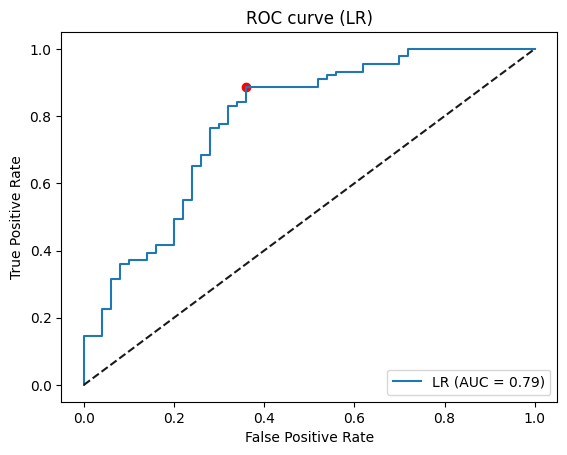

In [77]:
model_pipe.fit(X_train, y_train)
pipeline_score(model_pipe, y_test, X_test, "LR")
lr_pipe = model_pipe # for later

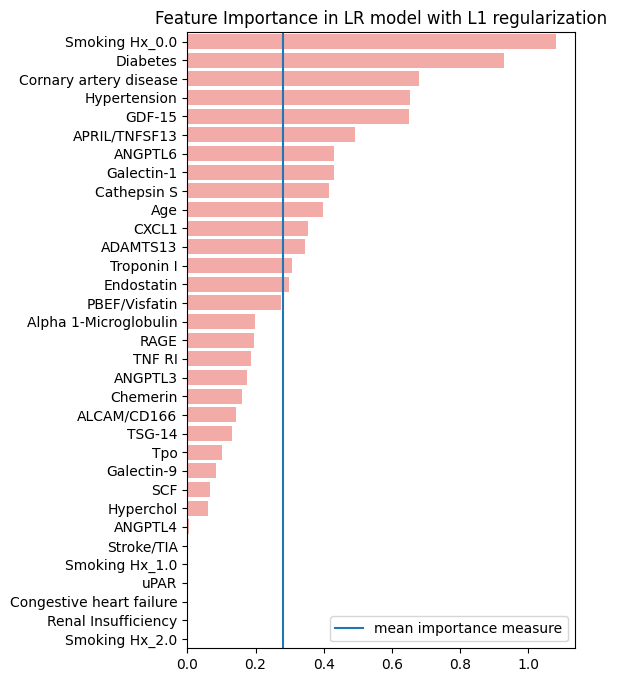

In [44]:
# using regex to extract name from feature names like below
# 'continous__Age'
# 'binary__Hypertension'
feature_names = [re.search("^(.*?)__(.*?)$", x).group(2) for x in model_pipe[:-1].get_feature_names_out()]

xx = pd.Series(np.abs(model_pipe["classifier"].coef_.squeeze()), index= feature_names).sort_values(ascending=False)
# top_LR = xx[:15].index
plot_importance(xx, "Feature Importance in LR model with L1 regularization")

In [45]:
# metrics.classification_report.

## Model 2: Random Forest

In [63]:
mod_rf = RandomForestClassifier(n_estimators=100, min_samples_split=2)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', mod_rf)
])

# model_pipe.fit(X_train, y_train)

param_grid = {
    'classifier__n_estimators': [10, 20, 50, 100, 200, 300, 500],
    'classifier__max_features': [None, 'sqrt', 'log2', 0.3, 0.4, 0.5],
    'classifier__min_samples_split': [2,4,8,16,32]
}

search = GridSearchCV(model_pipe,
                      param_grid,
                      cv=StratifiedKFold(5),
                      n_jobs=-1,
                      scoring="roc_auc",
                      return_train_score=True)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# test
# pipeline_score(model_pipe, y_test, X_test, "Random Forest")


Best parameter (CV score=0.756):
{'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}


Test AUC Performance on Random Forest = 0.776
Train AUC Performance on Random Forest = 1.000
Best Threshold=0.490000


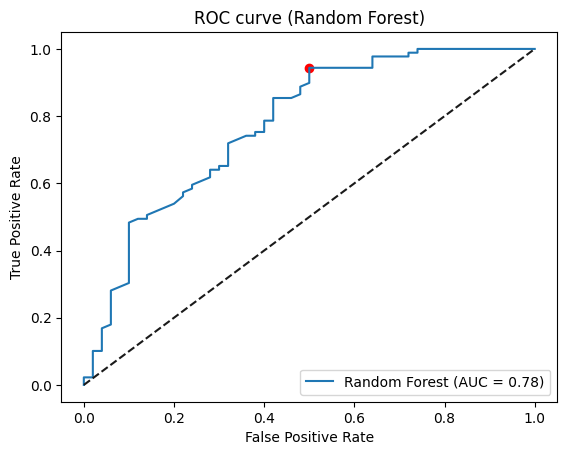

In [64]:
# now training the rf model on tuned params and test on unseen data
tuned_params = search.best_estimator_['classifier'].get_params()
mod_rf = RandomForestClassifier(**tuned_params)

rf_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', mod_rf)
])

rf_pipe.fit(X_train, y_train)
pipeline_score(rf_pipe, y_test, X_test, "Random Forest")

## Model 3: GBM 

In [65]:
param_grid_1 = {
    # 'loss': ['log_loss', 'exponential'],
    'max_depth': range(3,10),
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'subsample': [0.7, 0.8, 0.9, 1] #stochastic gradient boosting
}
param_grid = {f"classifier__{k}":v for k,v in param_grid_1.items()}

clf = GradientBoostingClassifier(loss='log_loss', random_state=42 )
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = RandomizedSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_iter = 100, scoring="roc_auc", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.759):
{'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.01}


In [67]:
tuned_params_1 = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**tuned_params_1)

param_grid_2 = {
    'max_features' : [None, 'sqrt', 'log2', 0.3, 0.4, 0.5, 0.6],
    'min_samples_split': [2,4,8,16,32,64],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
    'criterion': ['friedman_mse', 'squared_error'],
    
}
param_grid = {f"classifier__{k}":v for k,v in param_grid_2.items()}

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = RandomizedSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_iter = 100, scoring="roc_auc", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.761):
{'classifier__min_samples_split': 16, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 0.6, 'classifier__criterion': 'friedman_mse'}


In [69]:
tuned_params_2 = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**tuned_params_2)

param_grid = {
    'classifier__ccp_alpha': np.linspace(0, 0.01, 50)
}

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = GridSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_jobs=-1, scoring="roc_auc", return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.761):
{'classifier__ccp_alpha': 0.004693877551020408}


### Final Tuned GBM results


Test AUC Performance on GBM = 0.805
Train AUC Performance on GBM = 0.966
Best Threshold=0.582107


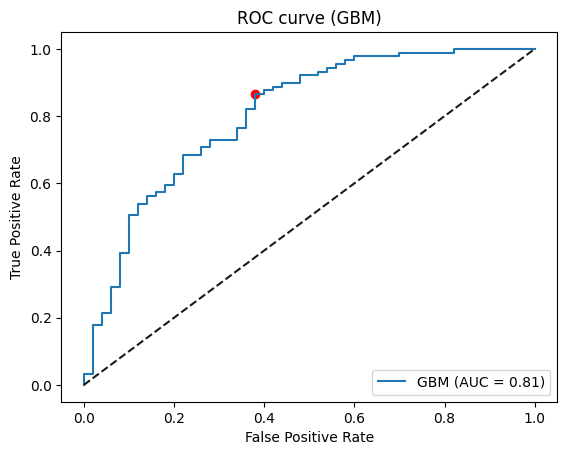

In [72]:
final_tuned = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**final_tuned)
gbm_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

gbm_pipe.fit(X_train, y_train)
pipeline_score(gbm_pipe, y_test, X_test, "GBM")

# Results

Here I will summarize the results for all 3 trained models.

- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. `precision = tp / (tp + fp)`
    + It is specifically useful when the cost of False positives is high.


- The recall (__Sensevity__) is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of true positives and ``fn`` the number of false negatives. The recall is
intuitively the ability of the classifier to find all the positive samples.

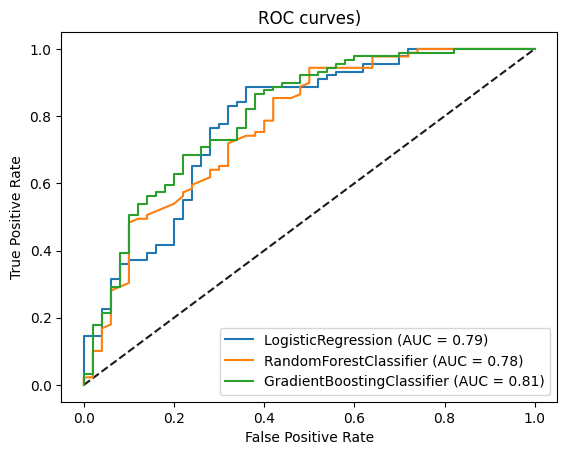

In [95]:
models = [lr_pipe ,rf_pipe, gbm_pipe]
res = pipeline_score_all(models, y_test, X_test)

In [96]:
res

,model,AUROC,prec,recall,F1,thr
0,LogisticRegression,0.785618,0.814433,0.887640,0.849462,0.456486
1,RandomForestClassifier,0.775506,0.770642,0.943820,0.848485,0.490000
2,GradientBoostingClassifier,0.805169,0.802083,0.865169,0.832432,0.582107


### Confusion matrix for top performing model

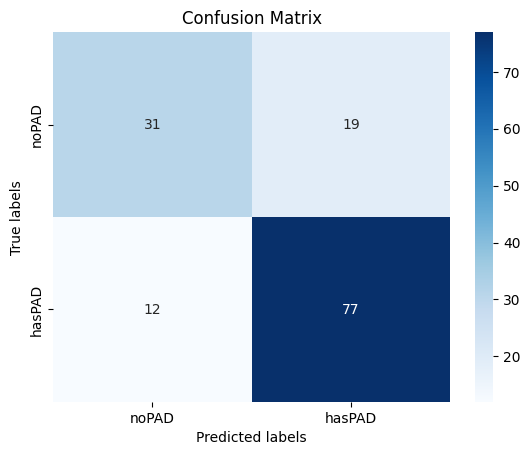

In [109]:
y_pred = (gbm_pipe.predict_proba(X_test)[:,1] >= res["thr"][2]).astype(int)
cm = metrics.confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues", ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['noPAD', 'hasPAD']); ax.yaxis.set_ticklabels(['noPAD', 'hasPAD']);

### Best proteins

Now looking at how each predictor (protein and clinical) was contributing to each model's success. The importance measure is scaled to (0,1) for better readability.

In [242]:
feature_names = [re.search("^(.*?)__(.*?)$", x).group(2) for x in lr_pipe[:-1].get_feature_names_out()]

feat_imp = pd.DataFrame({'LR': np.abs(lr_pipe['classifier'].coef_.squeeze()),
"RF": rf_pipe['classifier'].feature_importances_.squeeze(),
"GBM": gbm_pipe['classifier'].feature_importances_.squeeze()}, index= feature_names)

feature_scaler = MinMaxScaler(feature_range=(0,1))
xx = feature_scaler.fit_transform(feat_imp)
xx = pd.DataFrame(xx, columns= feat_imp.keys(), index = feature_names)
xx["sum_importance"] = xx.sum(axis=1)
xx.round(3)

,LR,RF,GBM,sum_importance
uPAR,0.000,0.548,0.133,0.681
SCF,0.060,0.441,0.086,0.587
TSG-14,0.122,0.441,0.080,0.643
RAGE,0.181,0.473,0.120,0.774
ADAMTS13,0.319,0.645,0.325,1.289
Tpo,0.095,0.376,0.034,0.505
TNF RI,0.172,0.492,0.111,0.775
ANGPTL3,0.161,0.648,0.255,1.064
ANGPTL4,0.004,0.508,0.055,0.568
CXCL1,0.326,0.577,0.210,1.113


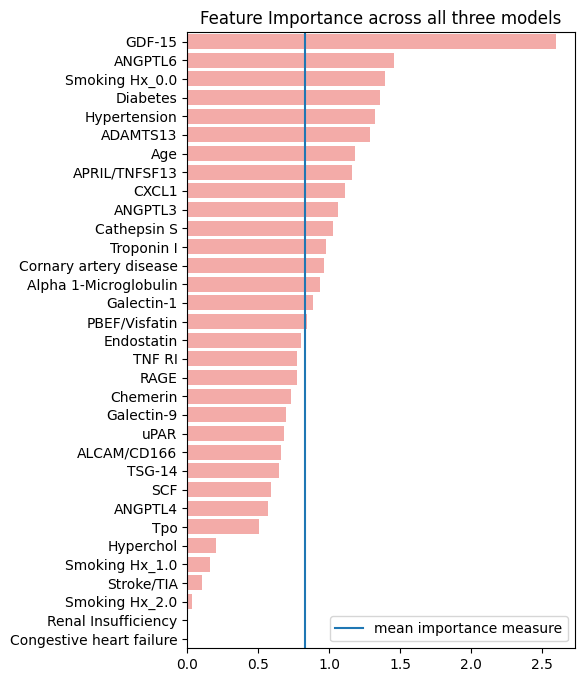

In [243]:
plot_importance(xx["sum_importance"].sort_values(ascending=False), "Feature Importance across all three models")

# Prognostic panel

Predict the occurance of complications in PAD patients

In [18]:
cp = pd.read_excel('./data/pad_complications.xlsx')
cp = cp.merge(df[["ID", "hasPAD"]])
cp = cp.loc[cp.hasPAD == 1]
cp.head()

,ID,Stent,PAD intervention,MI,STROKE,LIMB LOSS,Death,GFR,hasPAD
166,16,L popliteal artery revascularized w/ drug-elut...,"R above knee fempop bypass, redo sx May 11, 2017",0,0,"R 4th + 5th ray amp May 18, 2017",0,>60 (2018),1
167,20,R SFA/pop stent Jan 2020. R SFA + popliteal ar...,R SFA/pop stent Jan 2020. R SFA + popliteal ar...,0,0,"R D1 ray amp, D2, D3 Feb 2019",0,>60,1
168,31,0,0,0,0,0,0,35-45,1
169,38,Balloon angioplasty of L SFA Apr 2019,Balloon angioplasty of L SFA Apr 2019,0,0,0,0,48 (2015),1
170,46,NaN,L fem-pop bypass Sep 2017. R ilio-profunda fem...,0,0,L AKA May 2018. R AKA Dec 2017,0,>60,1


In [19]:
cp.isna().sum().to_frame().rename(columns = {0:"# of missing"})

,# of missing
ID,0
Stent,42
PAD intervention,0
MI,0
STROKE,0
LIMB LOSS,0
Death,0
GFR,10
hasPAD,0


> Variables `GFR` and `Stent` include Null values. GFR needs further information on how to code as outcome

These 5 complications are analysed in the prognostic phase for now:

'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS', 'Death'

In [36]:
cp["c_strk"] = 1
cp.loc[cp['STROKE'] == 0, 'c_strk'] = 0
# print(cp.c_strk.value_counts())

cp["c_death"] = 1
cp.loc[cp['Death'] == 0, 'c_death'] = 0
# print(cp.c_death.value_counts())

cp["c_mi"] = 1
cp.loc[cp['MI'] == 0, 'c_mi'] = 0
# print(cp.c_mi.value_counts())

cp["c_interv"] = 1
cp.loc[cp['PAD intervention'] == 0, 'c_interv'] = 0

cp["c_limbloss"] = 1
cp.loc[cp['LIMB LOSS'] == 0, 'c_limbloss'] = 0

## add new complications

cp["c_mace"] = cp['c_strk'] | cp["c_death"] | cp["c_mi"]
cp["c_male"] = cp['c_interv'] | cp["c_limbloss"]


In [37]:
xx = cp[[col for col in cp.columns if col.startswith("c_")]].apply(pd.value_counts)
xx.loc[xx.shape[0], :] = (xx.iloc[1,:] / xx.iloc[0,:] * 100 ).round(0)
xx.index = [0,1, 'Imbalanced %']
xx.rename_axis("Complications", axis =1 ).rename_axis("info", axis = 0)

Complications,c_strk,c_death,c_mi,c_interv,c_limbloss,c_mace,c_male
info,,,,,,,
0,277.0,288.0,245.0,219.0,277.0,230.0,211.0
1,18.0,7.0,50.0,76.0,18.0,65.0,84.0
Imbalanced %,6.0,2.0,20.0,35.0,6.0,28.0,40.0


> Note: Prediction of each complication in PAD patients, requires a seperate modeling phase. Current features need to be extracted based on their strengths and models need to be seperately tuned and trained for each outcome.

## 1- Stroke

First we start by basic getting the basic statistics with Stroke as a target variable

In [38]:
TARGET = 'c_strk'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [81]:

def highlight(row):
    '''
    highlight the pandas tableone frames for significant variables
    '''
    x = row.loc['Grouped by c_strk', 'P-Value'].strip()
    if len(x)< 2:
        return ['background-color: None'] * len(row)
    elif x.startswith("<") or float(x) <= 0.05:
        return ['background-color: red'] * len(row)
    else:
        return ['background-color: None'] * len(row)

table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

In [77]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

Create feature panel for prediction, according to univariate test. There are no significant proteins for Stroke.

In [82]:

final_clinical = [
    'Gender',
    'Hypertension',
    'Hyperchol',
    'Diabetes',
    'Renal Insufficiency',
    'Smoking Hx',
    'Congestive heart failure',
    'Cornary artery disease',
    'Stroke/TIA',
    #  'statin',
    #  'ACEi/ARB',
    'B-bl',
    #  'CCB',
    'HCTZ, Lasix',
    'Insulin'
]

numerical_final = [x for x in PROTEINS if x not in ('TNF RII',  'CD40', 'NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

# correlation check
# print(get_top_abs_correlations(newdf[final_clinical], 10))
# print(get_top_abs_correlations(newdf[PROTEINS], 10))

# contstructing the preprocessing piplines

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"))

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehot", OneHotEncoder(drop=None))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)


total number of features used as input to pipline = 55
Test AUC Performance on LR = 0.429
Best Threshold=0.023138


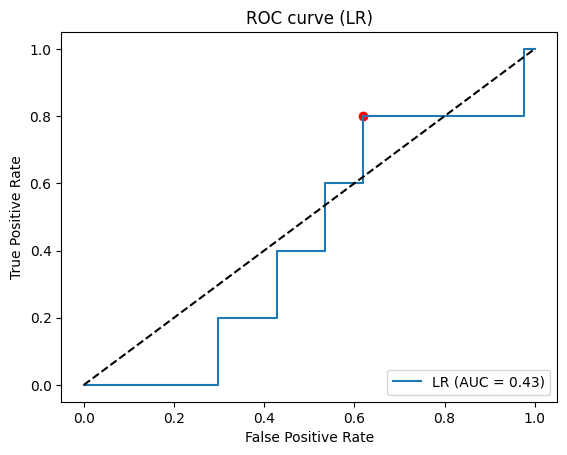

In [83]:
# newX = newdf[numerical_final + binary_final + cat_final].copy()
newX = newdf[numerical_final + binary_final + cat_final].copy()

print(f"total number of features used as input to pipline = {newX.shape[1]}")
y = newdf[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

myModel = LogisticRegression(penalty= "l1", solver= 'liblinear',random_state= 42)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])

model_pipe.fit(X_train, y_train)
pipeline_score(model_pipe, y_test, X_test, "LR")
# pipeline_score(model_pipe, y_train, X_train, "LR")

In [220]:
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
# print(f"Test AUC Performance on {clf_name} = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
# print(f"Train AUC Performance on {clf_name} = {metrics.roc_auc_score(y_train, pipe.predict_proba(X_train)[:,1]):.3f}")

prec, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
# get the best threshold - Youan's Index
f1 =  2 * (prec * recall) / (prec + recall)
ix = np.argmax(f1)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.071426


C:\Users\MacREAL3\AppData\Local\Temp\ipykernel_27980\2171912655.py:7: RuntimeWarning: invalid value encountered in divide
  f1 =  2 * (prec * recall) / (prec + recall)


<AxesSubplot: ylabel='Count'>

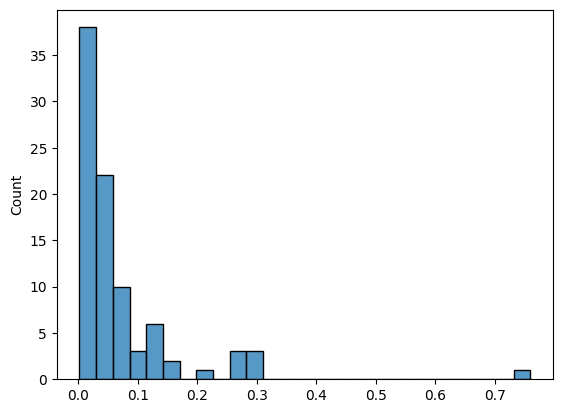

In [221]:
sns.histplot(y_pred_prob)

In [209]:
thresholds

f1s = [metrics.f1_score(y_test, (y_pred_prob > thr).astype(int)) for thr in thresholds]

In [210]:
thresholds[np.argmax(f1s)]

0.06263236853050187

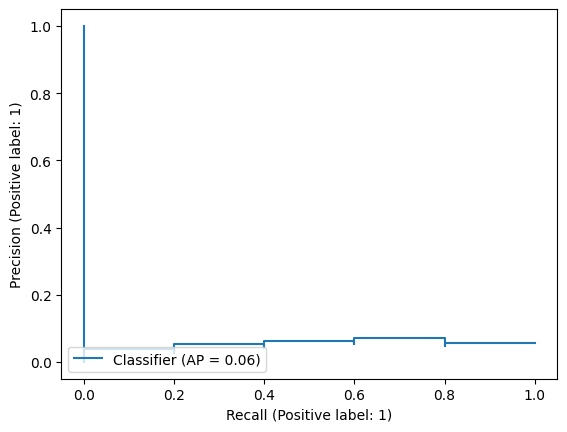

In [203]:
metrics.PrecisionRecallDisplay(y_test, y_pred_prob)

## 2- Death

In [245]:
TARGET = 'c_death'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [78]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

In [79]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis =1)

## 3- Myocardial Infarction (MI)

In [249]:
TARGET = 'c_mi'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [80]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

In [251]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

Grouped by c_mi                                             
                                             Missing     Overall           0            1 P-Value
n                                                            295         245           50        
Age, mean (SD)                                     1  71.4 (9.8)  71.4 (9.5)  71.7 (11.0)   0.856
Gender, mean (SD)                                  1   0.7 (0.5)   0.7 (0.5)    0.8 (0.4)   0.131
Hypertension, mean (SD)                            2   0.9 (0.3)   0.9 (0.4)    0.9 (0.3)   0.366
Hyperchol, mean (SD)                               2   0.8 (0.4)   0.8 (0.4)    0.8 (0.4)   0.993
Diabetes, mean (SD)                                0   0.5 (0.5)   0.4 (0.5)    0.6 (0.5)   0.029
Renal Insufficiency, mean (SD)                     0   0.0 (0.2)   0.0 (0.2)    0.0 (0.2)   0.915
Smoking Hx, mean (SD)                              2   1.0 (0.6)   1.0 (0.6)    1.0 (0.7)   0.909
Congestive heart failure, mean (SD)                3   0.1 (0.2)   0.1 (0.2)    0.1 (0.3)   0.357
Cornary artery disease, mean (SD)                  2   0.4 (0.5)   0.4 (0.5)    0.6 (0.5)   0.042
Stroke/TIA, mean (SD)                             12   0.2 (0.4)   0.2 (0.4)    0.2 (0.4)   0.430
statin, mean (SD)                                 19   0.9 (0.3)   0.9 (0.3)    0.9 (0.3)   0.363
ACEi/ARB, mean (SD)                               20   0.7 (0.5)   0.7 (0.5)    0.7 (0.5)   0.508
B-bl, mean (SD)                                   21   0.4 (0.5)   0.4 (0.5)    0.5 (0.5)   0.283
CCB, mean (SD)                                    20   0.3 (0.5)   0.3 (0.4)    0.4 (0.5)   0.077
HCTZ, Lasix, mean (SD)                            21   0.1 (0.4)   0.1 (0.3)    0.2 (0.4)   0.350
Insulin, mean (SD)                                21   0.1 (0.3)   0.1 (0.3)    0.1 (0.3)   0.490

## 4- PAD intervention

In [260]:
TARGET = 'c_interv'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [261]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

Grouped by c_interv                                                                                
                                                      Missing                 Overall                       0                       1 P-Value
n                                                                                 295                     219                      76        
IL-33, mean (SD)                                            0             27.2 (15.3)             27.9 (16.3)             25.3 (12.1)   0.138
uPAR, mean (SD)                                             9          2020.8 (979.5)         2090.7 (1025.4)          1816.8 (803.0)   0.021
CXCL6, mean (SD)                                            0           235.3 (163.9)           243.1 (180.6)            212.8 (99.1)   0.071
ESM-1, mean (SD)                                            0           592.2 (278.8)           601.4 (276.9)           565.5 (284.3)   0.342
SCF, mean (SD)                                              7            117.6 (52.6)            124.6 (56.0)             97.1 (33.4)  <0.001
TSG-14, mean (SD)                                          10          1387.1 (687.3)          1421.7 (759.4)          1286.6 (399.8)   0.055
IL-2, mean (SD)                                             0             73.0 (33.0)             75.0 (34.3)             67.3 (28.5)   0.056
PCSK9, mean (SD)                                            0     177207.1 (567648.3)     189583.9 (653757.9)     141542.4 (138118.0)   0.307
RAGE, mean (SD)                                             0         2582.2 (1681.9)         2666.9 (1816.5)         2338.0 (1190.0)   0.075
CD62P, mean (SD)                                            0       32620.2 (12084.3)       32462.7 (12038.2)       33074.1 (12285.3)   0.708
ADAMTS13, mean (SD)                                         8    1021613.4 (446577.8)    1037684.3 (427226.5)     976186.4 (497503.3)   0.342
Tpo, mean (SD)                                              3          1612.9 (864.9)          1632.9 (946.3)          1556.3 (575.6)   0.407
Tie-2, mean (SD)                                            0        16369.3 (8760.8)        16111.4 (8619.4)        17112.5 (9174.2)   0.407
KIM-1, mean (SD)                                            0            101.7 (84.5)            100.7 (71.9)           104.6 (113.9)   0.780
ICAM-1, mean (SD)                                           0     734235.7 (625186.5)     770260.6 (690980.3)     630427.1 (360077.5)   0.026
Angiopoietin-1, mean (SD)                                   0       10893.5 (11702.7)       11372.3 (12863.2)         9513.8 (7301.7)   0.125
TNF RII, mean (SD)                                          5         3387.4 (2513.8)         3633.3 (2790.3)         2669.6 (1177.0)  <0.001
TNF RI, mean (SD)                                           0         1919.2 (1487.2)         2057.2 (1661.6)          1521.6 (655.3)  <0.001
BMP-2, mean (SD)                                            0             40.1 (20.9)             41.0 (21.9)             37.3 (17.4)   0.139
ANGPTL3, mean (SD)                                          0       45571.2 (22167.6)       47058.9 (22730.5)       41284.0 (19985.0)   0.038
ANGPTL4, mean (SD)                                          0      192550.7 (99812.5)     199800.5 (105142.8)      171659.8 (79524.7)   0.016
CD40 Ligand, mean (SD)                                      0         2280.1 (1924.2)         2325.5 (2073.0)         2149.3 (1413.9)   0.412
CD40, mean (SD)                                             0           530.4 (548.0)           566.8 (624.4)           425.2 (169.7)   0.003
CXCL1, mean (SD)                                           10           251.1 (174.0)           255.7 (197.4)            237.5 (66.5)   0.247
NT- pro BNP, mean (SD)                                     29          330.5 (1581.2)          367.4 (1833.5)           227.2 (295.1)   0.302
Ck-MB, mean (SD)                                           29     

In [262]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

Grouped by c_interv                                             
                                                 Missing     Overall           0            1 P-Value
n                                                                295         219           76        
Age, mean (SD)                                         1  71.4 (9.8)  73.0 (9.1)  66.9 (10.3)  <0.001
Gender, mean (SD)                                      1   0.7 (0.5)   0.6 (0.5)    0.8 (0.4)   0.002
Hypertension, mean (SD)                                2   0.9 (0.3)   0.9 (0.4)    0.9 (0.3)   0.354
Hyperchol, mean (SD)                                   2   0.8 (0.4)   0.8 (0.4)    0.9 (0.4)   0.659
Diabetes, mean (SD)                                    0   0.5 (0.5)   0.4 (0.5)    0.5 (0.5)   0.100
Renal Insufficiency, mean (SD)                         0   0.0 (0.2)   0.0 (0.2)    0.0 (0.1)   0.094
Smoking Hx, mean (SD)                                  2   1.0 (0.6)   1.0 (0.6)    1.2 (0.7)   0.010
Congestive heart failure, mean (SD)                    3   0.1 (0.2)   0.1 (0.2)    0.1 (0.3)   0.572
Cornary artery disease, mean (SD)                      2   0.4 (0.5)   0.4 (0.5)    0.5 (0.5)   0.029
Stroke/TIA, mean (SD)                                 12   0.2 (0.4)   0.2 (0.4)    0.2 (0.4)   0.492
statin, mean (SD)                                     19   0.9 (0.3)   0.9 (0.3)    0.9 (0.3)   0.271
ACEi/ARB, mean (SD)                                   20   0.7 (0.5)   0.6 (0.5)    0.8 (0.4)   0.010
B-bl, mean (SD)                                       21   0.4 (0.5)   0.4 (0.5)    0.4 (0.5)   0.898
CCB, mean (SD)                                        20   0.3 (0.5)   0.3 (0.5)    0.3 (0.4)   0.529
HCTZ, Lasix, mean (SD)                                21   0.1 (0.4)   0.2 (0.4)    0.1 (0.3)   0.029
Insulin, mean (SD)                                    21   0.1 (0.3)   0.1 (0.3)    0.2 (0.4)   0.113

## 5- Limb Loss

In [254]:
TARGET = 'c_limbloss'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [255]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

Grouped by c_limbloss                                                                                
                                                        Missing                 Overall                       0                       1 P-Value
n                                                                                   295                     277                      18        
IL-33, mean (SD)                                              0             27.2 (15.3)             27.2 (15.6)             27.5 (11.3)   0.918
uPAR, mean (SD)                                               9          2020.8 (979.5)          1996.1 (968.2)         2389.1 (1099.5)   0.156
CXCL6, mean (SD)                                              0           235.3 (163.9)           238.2 (167.5)            190.3 (83.5)   0.039
ESM-1, mean (SD)                                              0           592.2 (278.8)           584.1 (273.3)           716.4 (337.5)   0.120
SCF, mean (SD)                                                7            117.6 (52.6)            117.8 (52.9)            114.3 (48.0)   0.784
TSG-14, mean (SD)                                            10          1387.1 (687.3)          1353.3 (668.6)          1888.9 (783.2)   0.011
IL-2, mean (SD)                                               0             73.0 (33.0)             73.0 (33.0)             73.4 (35.1)   0.960
PCSK9, mean (SD)                                              0     177207.1 (567648.3)     180804.7 (585048.1)     121843.7 (109981.2)   0.180
RAGE, mean (SD)                                               0         2582.2 (1681.9)         2599.9 (1701.6)         2309.8 (1352.3)   0.396
CD62P, mean (SD)                                              0       32620.2 (12084.3)       32580.9 (12224.7)        33224.7 (9940.4)   0.796
ADAMTS13, mean (SD)                                           8    1021613.4 (446577.8)    1027853.2 (450124.9)     928362.3 (388839.3)   0.311
Tpo, mean (SD)                                                3          1612.9 (864.9)          1618.6 (888.5)          1526.8 (348.2)   0.356
Tie-2, mean (SD)                                              0        16369.3 (8760.8)        16248.9 (8929.1)        18222.3 (5391.1)   0.166
KIM-1, mean (SD)                                              0            101.7 (84.5)            103.2 (86.0)             78.2 (53.5)   0.080
ICAM-1, mean (SD)                                             0     734235.7 (625186.5)     725025.1 (621312.2)     875976.2 (685273.6)   0.374
Angiopoietin-1, mean (SD)                                     0       10893.5 (11702.7)       11090.0 (11995.1)         7869.5 (4710.6)   0.020
TNF RII, mean (SD)                                            5         3387.4 (2513.8)         3355.5 (2550.1)         3898.8 (1815.4)   0.258
TNF RI, mean (SD)                                             0         1919.2 (1487.2)         1890.7 (1499.5)         2357.8 (1236.0)   0.141
BMP-2, mean (SD)                                              0             40.1 (20.9)             39.8 (21.2)             44.5 (15.8)   0.243
ANGPTL3, mean (SD)                                            0       45571.2 (22167.6)       46238.3 (22045.9)       35304.8 (22108.6)   0.056
ANGPTL4, mean (SD)                                            0      192550.7 (99812.5)      190234.6 (99173.9)     228192.3 (105732.2)   0.155
CD40 Ligand, mean (SD)                                        0         2280.1 (1924.2)         2288.6 (1942.4)         2148.5 (1660.8)   0.735
CD40, mean (SD)                                               0           530.4 (548.0)           525.0 (558.2)           613.2 (356.4)   0.340
CXCL1, mean (SD)                                             10           251.1 (174.0)           251.7 (178.1)            241.0 (89.5)   0.663
NT- pro BNP, mean (SD)                                       29          330.5 (1581.2)          340.2 (1633.4)           188.0 (178.7)   0.176
Ck-MB, mea

In [256]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

Grouped by c_limbloss                                            
                                                   Missing     Overall           0           1 P-Value
n                                                                  295         277          18        
Age, mean (SD)                                           1  71.4 (9.8)  71.5 (9.8)  69.4 (9.4)   0.361
Gender, mean (SD)                                        1   0.7 (0.5)   0.7 (0.5)   0.8 (0.4)   0.302
Hypertension, mean (SD)                                  2   0.9 (0.3)   0.9 (0.3)   0.9 (0.2)   0.201
Hyperchol, mean (SD)                                     2   0.8 (0.4)   0.8 (0.4)   0.7 (0.5)   0.274
Diabetes, mean (SD)                                      0   0.5 (0.5)   0.4 (0.5)   0.8 (0.4)   0.004
Renal Insufficiency, mean (SD)                           0   0.0 (0.2)   0.0 (0.2)   0.1 (0.2)   0.735
Smoking Hx, mean (SD)                                    2   1.0 (0.6)   1.0 (0.6)   1.1 (0.9)   0.663
Congestive heart failure, mean (SD)                      3   0.1 (0.2)   0.1 (0.2)   0.1 (0.3)   0.504
Cornary artery disease, mean (SD)                        2   0.4 (0.5)   0.4 (0.5)   0.4 (0.5)   0.479
Stroke/TIA, mean (SD)                                   12   0.2 (0.4)   0.2 (0.4)   0.1 (0.3)   0.296
statin, mean (SD)                                       19   0.9 (0.3)   0.9 (0.3)   0.7 (0.5)   0.151
ACEi/ARB, mean (SD)                                     20   0.7 (0.5)   0.7 (0.5)   0.8 (0.4)   0.314
B-bl, mean (SD)                                         21   0.4 (0.5)   0.4 (0.5)   0.4 (0.5)   0.888
CCB, mean (SD)                                          20   0.3 (0.5)   0.3 (0.5)   0.3 (0.5)   0.875
HCTZ, Lasix, mean (SD)                                  21   0.1 (0.4)   0.1 (0.4)   0.1 (0.3)   0.722
Insulin, mean (SD)                                      21   0.1 (0.3)   0.1 (0.3)   0.3 (0.5)   0.061

# Appendix

### Exploring the warning raised by Hartigan's Dip Test

In [22]:
df[["KIM-1", "BMP-2", "CXCL1", "PBEF/Visfatin"]].describe().round(2)

,KIM-1,BMP-2,CXCL1,PBEF/Visfatin
count,461.00,461.00,443.00,444.00
mean,100.45,40.65,237.50,24587.49
std,80.77,18.63,152.28,57667.35
min,16.99,6.19,4.09,83.19
25%,51.97,27.94,159.98,5838.81
50%,78.22,45.50,217.60,10283.50
75%,124.44,52.39,269.66,17858.68
max,855.40,259.94,2060.37,548781.55


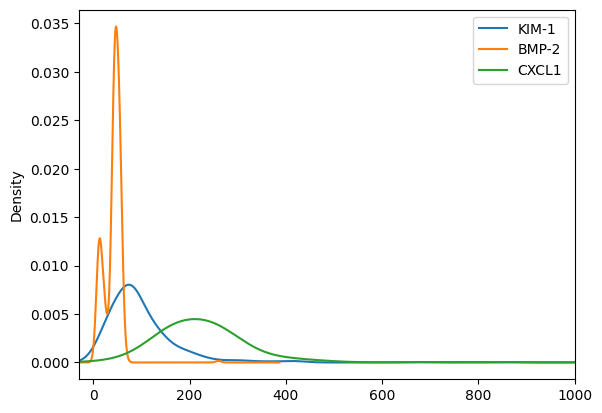

In [23]:
df[["KIM-1", "BMP-2", "CXCL1"]].dropna().plot.kde()
plt.xlim([-30, 1000])
plt.show()

> Protein BMP-2 appears to have a bimodal distribution (non-normality)

<AxesSubplot: ylabel='Density'>

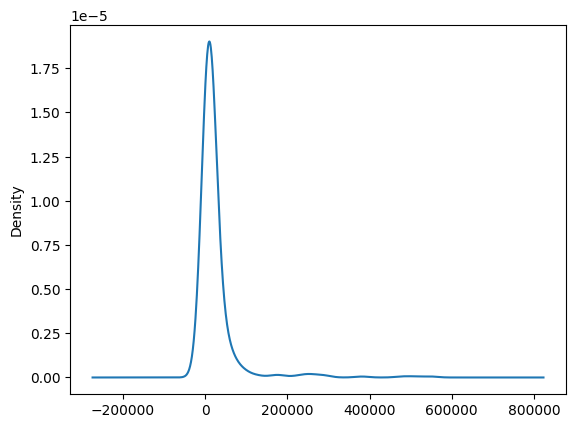

In [24]:
df["PBEF/Visfatin"].dropna().plot.kde()
## possibly outliers

In [25]:
### Trying on a smaller subset of proteins

In [117]:
## proteins with significant anova test from prev file

num_feat_selected = ['uPAR', 'SCF', 'TSG-14', 'RAGE', 'ADAMTS13', 'Tpo', 'TNF RII', 'TNF RI',
       'ANGPTL3', 'ANGPTL4', 'CD40', 'CXCL1', 'NT- pro BNP', 'Troponin I',
       'ANGPTL6', 'Alpha 1-Microglobulin', 'Galectin-9', 'PBEF/Visfatin',
       'Cathepsin S', 'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'GDF-15',
       'Chemerin', 'Endostatin', 'Age']

table2 = TableOne(df_viz, columns = num_feat_selected,  dip_test=True, normal_test=True, tukey_test=True)
table2

,,Missing,Overall
n,,,461
"uPAR, mean (SD)",,15,1910.5 (959.5)
"SCF, mean (SD)",,15,111.9 (49.0)
"TSG-14, mean (SD)",,14,1324.6 (636.0)
"RAGE, mean (SD)",,7,2461.3 (1462.5)
"ADAMTS13, mean (SD)",,12,1077422.7 (501757.5)
"Tpo, mean (SD)",,9,1544.8 (755.4)
"TNF RII, mean (SD)",,13,3119.0 (2191.3)
"TNF RI, mean (SD)",,0,1785.6 (1337.7)
"ANGPTL3, mean (SD)",,0,47866.8 (22404.5)


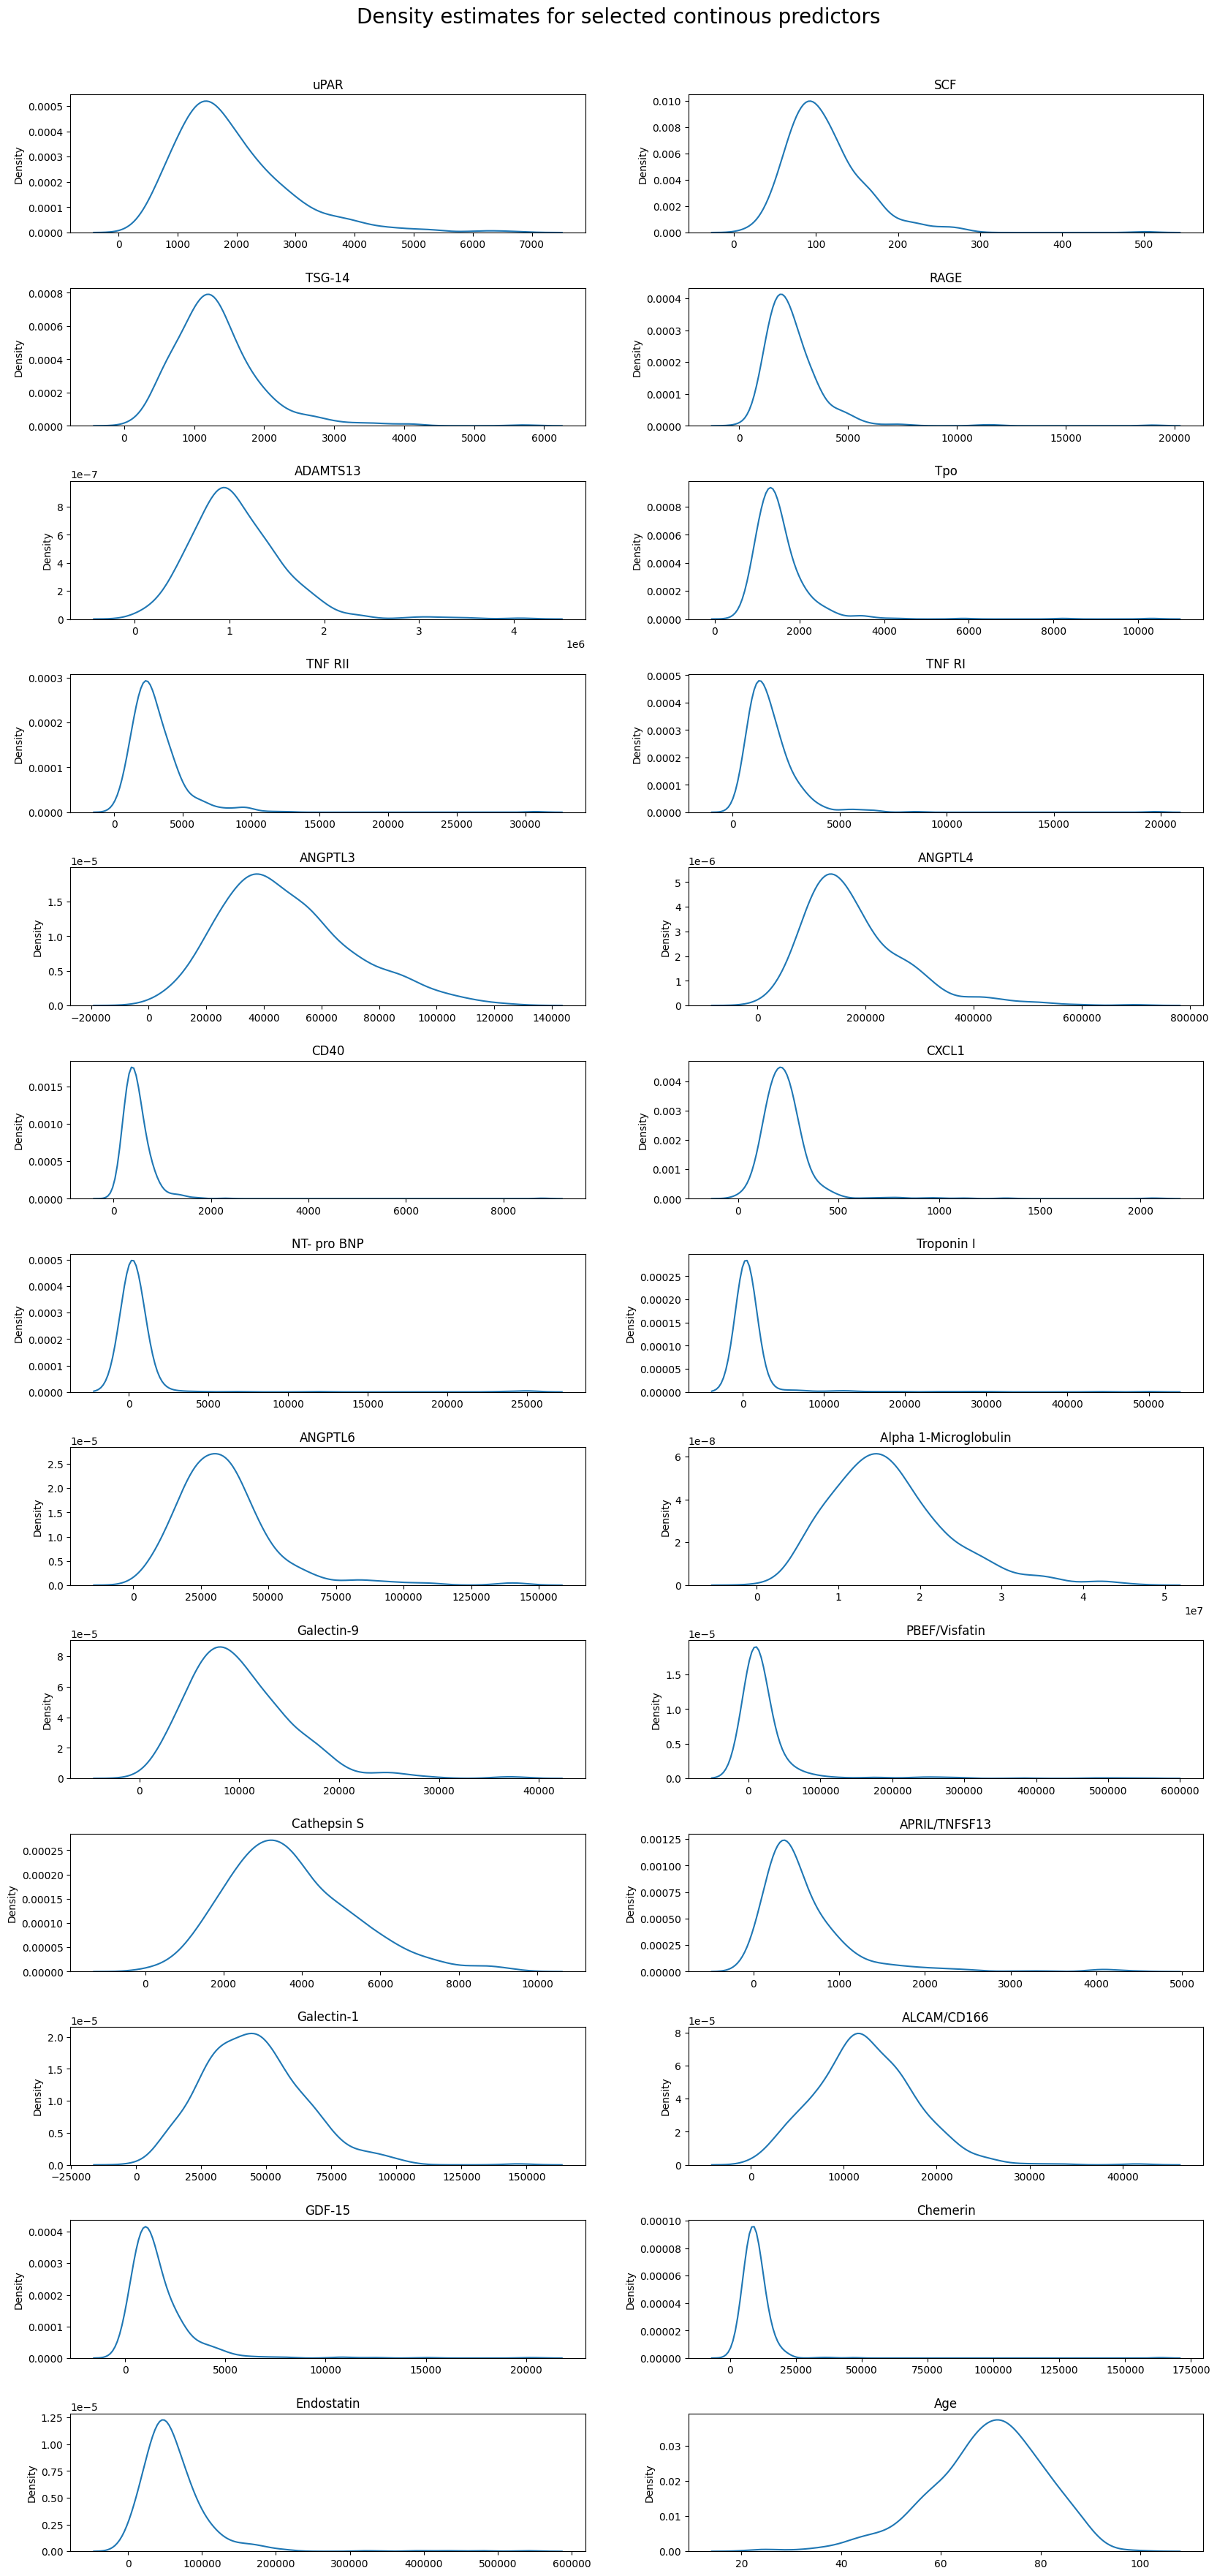

In [27]:
n = len(num_feat_selected)
fig, axs = plt.subplots(nrows = n//2, ncols = 2, figsize = (20,40))
fig.subplots_adjust(hspace=.4, top = .95) #space between subplots
fig.suptitle("Density estimates for selected continous predictors",size=20)
for col, ax in zip(num_feat_selected, axs.ravel()):
    g = sns.kdeplot(df[col], ax= ax)
    g.set_title(str(col))
    g.set_xlabel("")
plt.show()

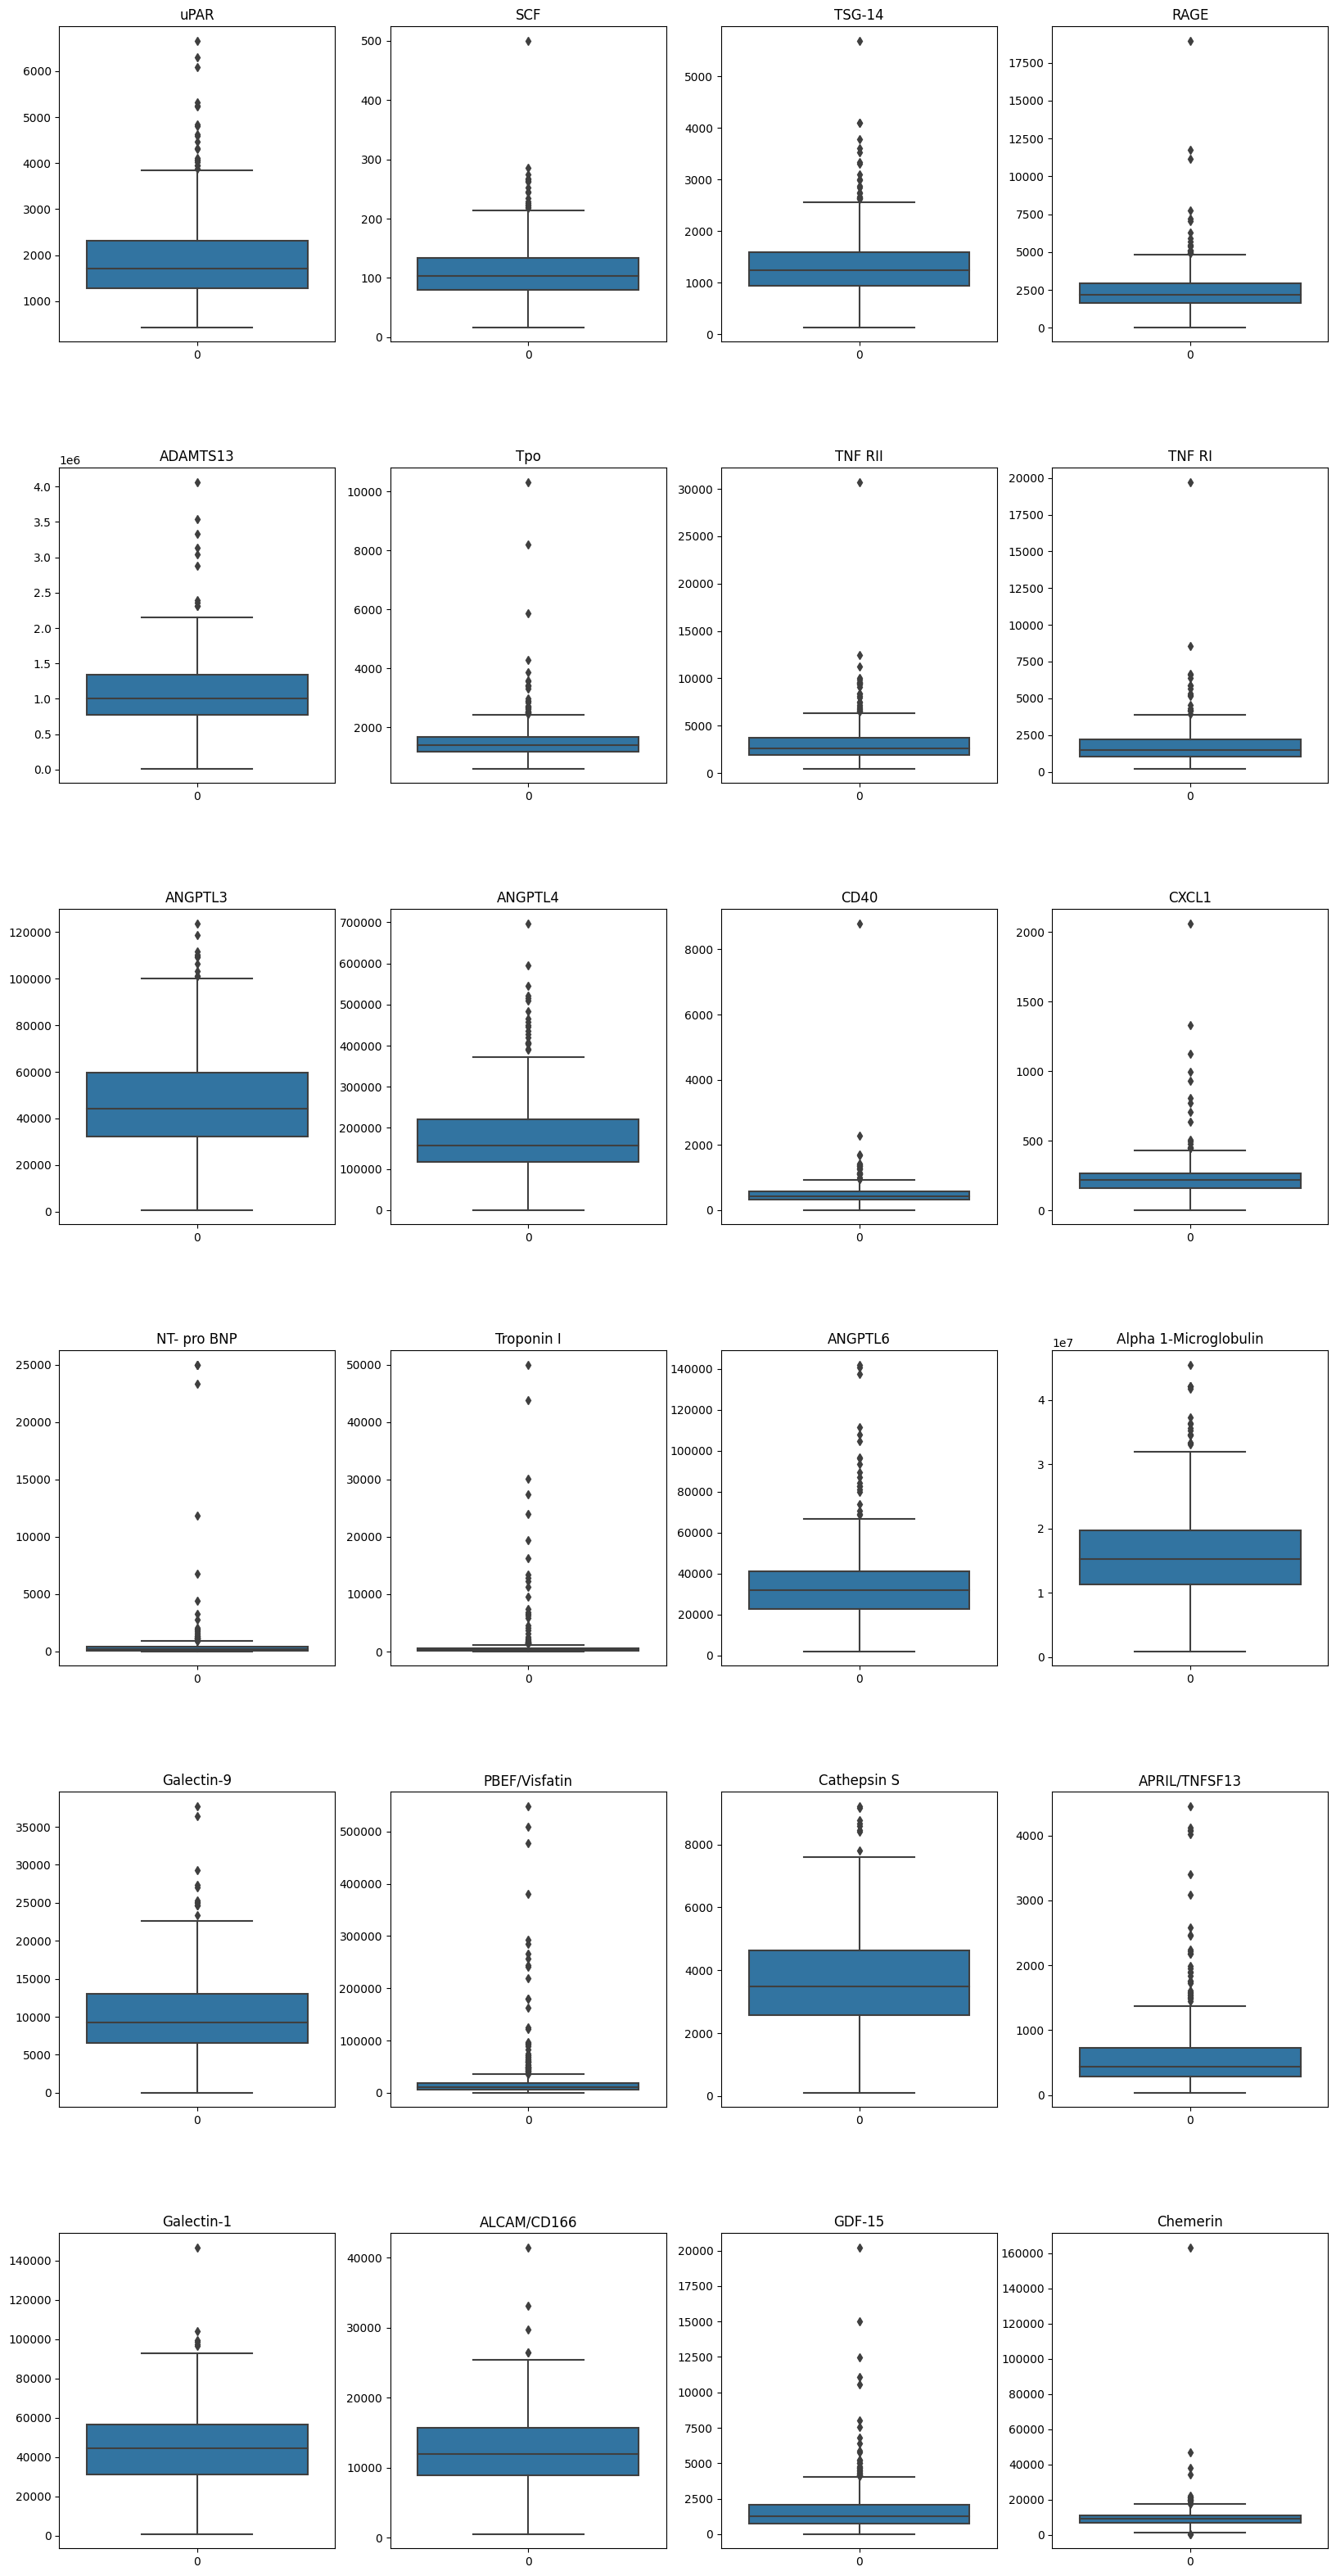

In [28]:
##outlier analysis

n = len(num_feat_selected)
fig, axs = plt.subplots(nrows = n//4, ncols = 4, figsize = (20,40))
plt.subplots_adjust(hspace=.4) #space between subplots
plt.title = "Box plot for selected proteins - outlier analysis"
for col, ax in zip(num_feat_selected, axs.ravel()):
    g = sns.boxplot(df[col], ax= ax)
    g.set_title(str(col))
    g.set_xlabel("")
plt.show()

## Comment about FABP3

The data shows no major difference between patient groups regarding this protein.

In [118]:
df[["FABP3 1value (pg/ml) baseline", "FABP4"]]
TableOne(df_viz, columns=["FABP3 1value (pg/ml) baseline", "FABP4"], groupby="hasPAD",  pval = True,
                  htest_name=True)

Grouped by hasPAD                                                                                    
                                                    Missing            Overall           With PAD        Without PAD P-Value               Test
n                                                                          461                295                166                           
FABP3 1value (pg/ml) baseline, mean (SD)                 36    3962.5 (2142.5)    3849.7 (2259.3)    4149.2 (1926.1)   0.147  Two Sample T-test
FABP4, mean (SD)                                         59  23640.7 (35467.4)  22309.4 (39661.2)  26187.4 (25540.6)   0.236  Two Sample T-test

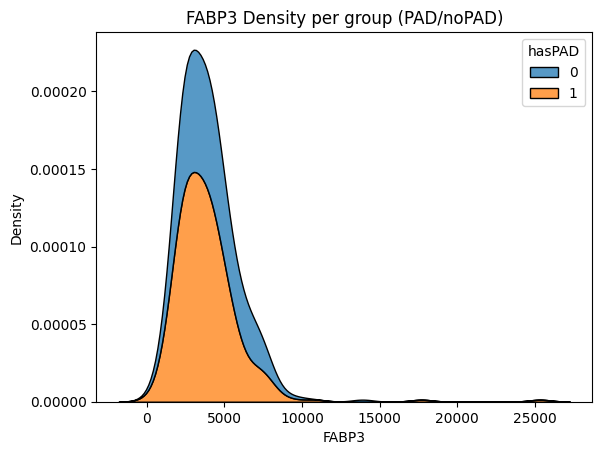

In [6]:
g = sns.kdeplot(df, x = "FABP3 1value (pg/ml) baseline", hue = "hasPAD", multiple="stack")
g.set_xlabel("FABP3")
g.set_title("FABP3 Density per group (PAD/noPAD)")
plt.show()